In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sf
import matplotlib as mpl
from astropy.io import ascii
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
from scipy.stats import binned_statistic
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [7,5]
#import Fraunhofer
%run Fraunhofer

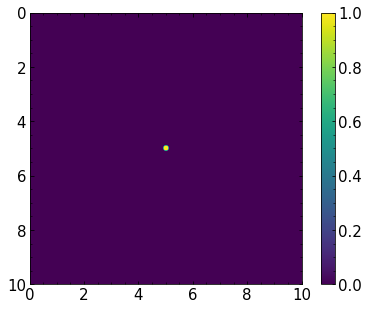

In [2]:

screen = {}
screen['N'] = 4096
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
#MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 0.1)
# c2 = (center[0]-0.2, center[1]-0.1)
CircleAtten(screen,center,0.1,1.)
# c2 = (center[0]+0.1, center[1]+0.3)
# CircleAtten(screen,c2,0.1,1/1.3)
# c2 = (center[0]+0.3, center[1]-0.1)
# CircleAtten(screen,c2,0.1,1.3)
# c2 = (center[0]-0.3, center[1]+0.2)
# CircleAtten(screen,c2,0.1,1/1.3)
ScreenFFT(screen)

lam = 0.002 #mm wavelength
kphot = 2*np.pi/lam
thetamaxdeg = 2.0
thetamax = thetamaxdeg*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,1024) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 
plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.colorbar()


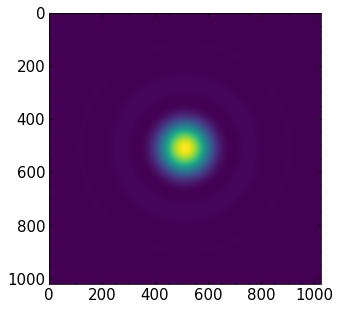

In [3]:
plt.imshow(II0)

In [5]:
(thetax, thetay) = np.meshgrid(theta_vec, theta_vec) # rad 
theta_r = np.sqrt(thetax**2 + thetay**2)
bin_edges = np.linspace(0,theta_r.max(),int(0.8*1024)) # bin radially
theta_flatten = theta_r.flatten()
I_flatten = II0.flatten()
bin_mean, bin_edge, bin_num = binned_statistic(theta_flatten, I_flatten, statistic='mean', bins=bin_edges) # calculate binned sky intensity


0.012199999999999999


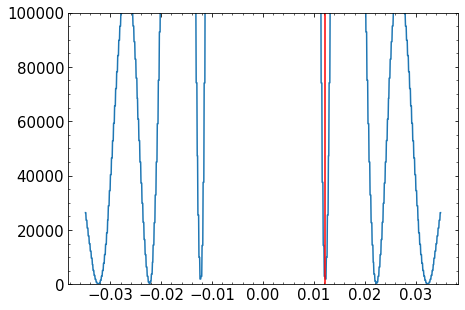

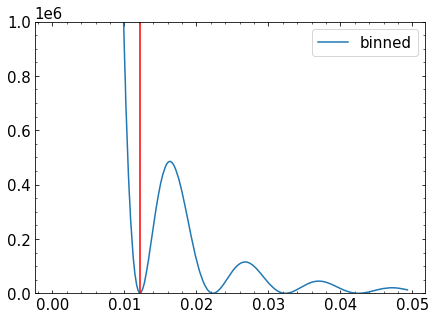

In [11]:
print(1.22*lam/0.2)
plt.plot(theta_vec, II0[int(len(II0)/2)])
plt.axvline(x=1.22*lam/0.2, color='red')
plt.ylim(0,1e5)
plt.show()
plt.plot(bin_edges[:-1], bin_mean,label='binned')
plt.axvline(x=1.22*lam/0.2, color='red')
plt.ylim(0,1e6)
plt.legend();
plt.show()

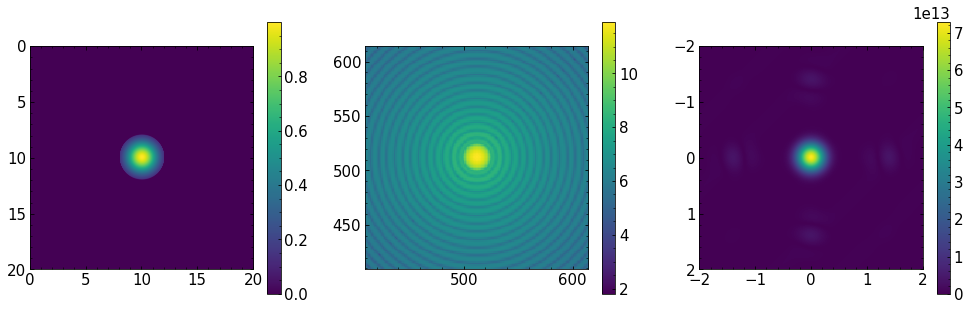

Fitted beam sigma in sky is 0.00023 radians


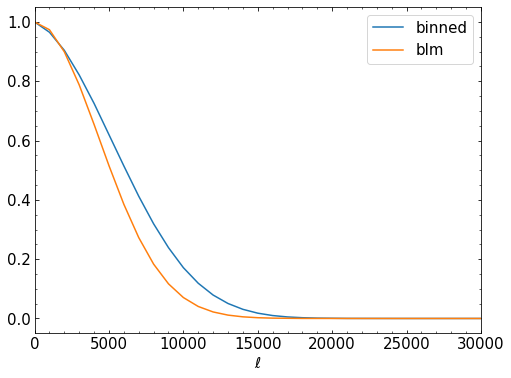

In [ ]:

# define beam and gaussian functions
def b_lm(l, sigma):
  #l = screen['kap']*np.pi*2
  blm = np.exp(-l*(l+1)*sigma**2/2)
  return(blm)
def sigma_calc(r,sigma):
  gaussian = bin_mean.max()*np.exp(-r**2/(2*sigma**2))
  return(gaussian)


# create screen [m]
screen = {}
screen['N'] = 8192
screen['D'] = 20
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 2.0)
ScreenFFT(screen)

# minimize Chi^2 
N_theta=1024
# interpolation in sky intensity [rad]
lam = 0.002 #mm wavelength
kphot = 2*np.pi/lam
thetamaxdeg = 2.0
thetamax = thetamaxdeg*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 

# FFT the sky intensity to ell space (ifft for comparison)
fft_iI = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(II0))) # ifft of sky intensity 
fft_I = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))   # fft of sky intensity (1/rad) 
blm_numerical = np.abs(fft_I)**2 #numerically calculated beam in [1/rad] k space
# plot the screen, interpolation, and fft of 
fig = plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.imshow(screen['E'],extent=(0, screen['D'], screen['D'], 0))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log10(II0))
plt.colorbar()
#plt.xlim(460,564)
#plt.ylim(460,564)
plt.xlim(int(0.4*N_theta),int(0.6*N_theta))
plt.ylim(int(0.4*N_theta),int(0.6*N_theta))
plt.subplot(1,3,3)
plt.imshow(np.abs(fft_I),extent=(-thetamaxdeg, thetamaxdeg, thetamaxdeg, -thetamaxdeg)) # plot absolute value of fft_I
plt.colorbar()
plt.show()

# calculate ell
n = theta_vec.shape[0]
dk = 1/theta_vec.max() # dk in 1/rad space
k_vec = dk*np.fft.fftshift(np.fft.fftfreq(n))*n
(k_x, k_y) = np.meshgrid(k_vec,k_vec) # 1/rad 
k_r = np.sqrt(k_x**2 + k_y**2)
l = k_r * 2 * np.pi
#plt.imshow(l)

# fit sigma in sky (rad)
(thetax, thetay) = np.meshgrid(theta_vec, theta_vec) # rad 
theta_r = np.sqrt(thetax**2 + thetay**2)
bin_edges = np.linspace(0,theta_r.max(),int(0.5*N_theta)) # bin radially
theta_flatten = theta_r.flatten()
I_flatten = II0.flatten()
bin_mean, bin_edge, bin_num = binned_statistic(theta_flatten, I_flatten, statistic='mean', bins=bin_edges) # calculate binned sky intensity
(fit, err) = opt.curve_fit(sigma_calc, bin_edges[0:-1], bin_mean, p0=1e-4, absolute_sigma=True) # fit the binned intensity for the beam width sigma
print('Fitted beam sigma in sky is {:.5f} radians'.format(fit[0]))

# average (FT of II0)^2 radially 
bin_edges = np.arange(0,l.max(),1000)
l_flatten = l.flatten()
beam_numerical_flatten = blm_numerical.flatten()
bin_mean, bin_edge, bin_num = binned_statistic(l_flatten, beam_numerical_flatten, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
l_vec = bin_edges[0:-1] # ell 1D vector
# plot the numerical beam and analytical beam
fig = plt.figure(figsize=(8,6))
plt.plot(l_vec,bin_mean/bin_mean.max(),label='binned') # normalize the numerical solution
plt.xlabel(r'$\ell$')
blm = b_lm(l_vec, fit[0]) # analytical solution
plt.plot(l_vec, blm,label='blm') # plot the analytical solution
plt.xlim(0,3e4)
plt.legend()
plt.show()




In [ ]:
# theta = 3 degrees
beam_theta3 = bin_mean.copy() #numerical
blm_theta3 = blm.copy() #analytical 
l_vec_3 = l_vec.copy()

In [ ]:
# theta = 2 degrees
beam_theta2 = bin_mean.copy() #numerical
blm_theta2 = blm.copy() #analytical 
l_vec_2 = l_vec.copy()

In [ ]:
# theta = 1 degrees
beam_theta1 = bin_mean.copy() #numerical
blm_theta1 = blm.copy() #analytical 
l_vec_1 = l_vec.copy()

In [ ]:
# theta = 4 degrees
beam_theta4 = bin_mean.copy() #numerical
blm_theta4 = blm.copy() #analytical 
l_vec_4 = l_vec.copy()

In [ ]:
# D = 5
beam_D5 = bin_mean.copy() #numerical
blm_D5 = blm.copy() #analytical 
l_vec_D5 = l_vec.copy()

In [ ]:
# D = 10
beam_D10 = bin_mean.copy() #numerical
blm_D10 = blm.copy() #analytical 
l_vec_D10 = l_vec.copy()

In [ ]:
# D = 15
beam_D15 = bin_mean.copy() #numerical
blm_D15 = blm.copy() #analytical 
l_vec_D15 = l_vec.copy()

In [ ]:
# D = 20
beam_D20 = bin_mean.copy() #numerical
blm_D20 = blm.copy() #analytical 
l_vec_D20 = l_vec.copy()

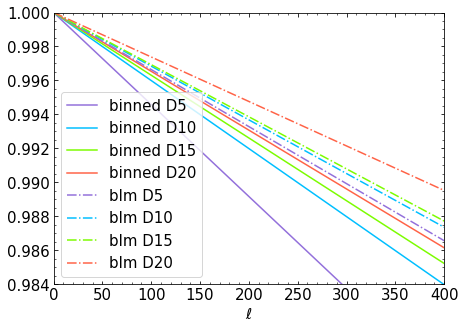

In [ ]:
plt.plot(l_vec_D5,beam_D5/beam_D5.max(),color='mediumpurple', label='binned D5') # normalize the numerical solution
plt.plot(l_vec_D10,beam_D10/beam_D10.max(),color='deepskyblue', label='binned D10') # normalize the numerical solution
plt.plot(l_vec_D15,beam_D15/beam_D15.max(),color='lawngreen', label='binned D15') # normalize the numerical solution
plt.plot(l_vec_D20,beam_D20/beam_D20.max(),color='tomato', label='binned D20') # normalize the numerical solution

plt.plot(l_vec_D5,blm_D5/blm_D5.max(),color='mediumpurple', ls='-.', label='blm D5') # analytical solution
plt.plot(l_vec_D10,blm_D10/blm_D10.max(),color='deepskyblue', ls='-.', label='blm D10') # analytical solution
plt.plot(l_vec_D15,blm_D15/blm_D15.max(),color='lawngreen', ls='-.', label='blm D15') # analytical solution
plt.plot(l_vec_D20,blm_D20/blm_D20.max(),color='tomato', ls='-.', label='blm D20') # analytical solution
plt.xlim(0,400)
#plt.xlim(0,1.4e4)
plt.xlabel(r'$\ell$')
plt.ylim(0.984,1)
plt.legend();

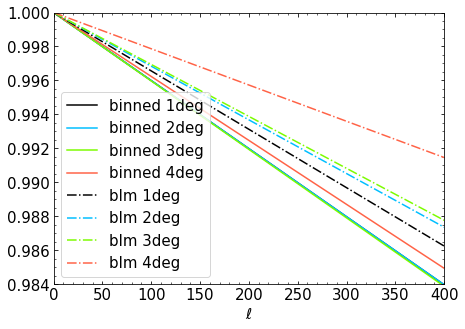

In [ ]:
plt.plot(l_vec_1,beam_theta1/beam_theta1.max(),color='black', label='binned 1deg') # normalize the numerical solution
plt.plot(l_vec_2,beam_theta2/beam_theta2.max(),color='deepskyblue', label='binned 2deg') # normalize the numerical solution
plt.plot(l_vec_3,beam_theta3/beam_theta3.max(),color='lawngreen', label='binned 3deg') # normalize the numerical solution
plt.plot(l_vec_4,beam_theta4/beam_theta4.max(),color='tomato', label='binned 4deg') # normalize the numerical solution

plt.plot(l_vec_1,blm_theta1/blm_theta1.max(),color='black', ls='-.', label='blm 1deg') # analytical solution
plt.plot(l_vec_2,blm_theta2/blm_theta2.max(),color='deepskyblue', ls='-.', label='blm 2deg') # analytical solution
plt.plot(l_vec_3,blm_theta3/blm_theta3.max(),color='lawngreen', ls='-.', label='blm 3deg') # analytical solution
plt.plot(l_vec_4,blm_theta4/blm_theta4.max(),color='tomato', ls='-.', label='blm 4deg') # analytical solution
plt.xlim(0,400)
#plt.xlim(0,1.4e4)
plt.xlabel(r'$\ell$')
plt.ylim(0.984,1)
plt.legend();

In [ ]:
# N = 512
beam_N512 = bin_mean.copy() #numerical
blm_N512 = blm.copy() #analytical 
l_vec_N512 = l_vec.copy()

In [ ]:
# N = 1024
beam_N1024 = bin_mean.copy() #numerical
blm_N1024 = blm.copy() #analytical 
l_vec_N1024 = l_vec.copy()

In [ ]:
# N = 2048
beam_N2048 = bin_mean.copy() #numerical
blm_N2048 = blm.copy() #analytical 
l_vec_N2048 = l_vec.copy()

In [ ]:
# N = 4096
beam_N4096 = bin_mean.copy() #numerical
blm_N4096 = blm.copy() #analytical 
l_vec_N4096 = l_vec.copy()

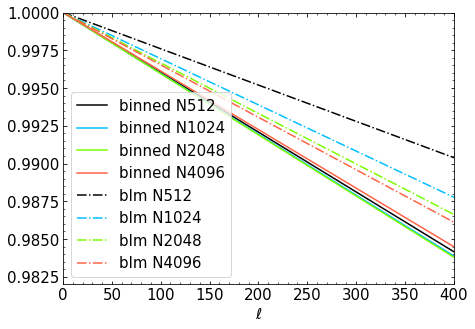

In [ ]:
plt.plot(l_vec_N512,beam_N512/beam_N512.max(),color='black', label='binned N512') # normalize the numerical solution
plt.plot(l_vec_N1024,beam_N1024/beam_N1024.max(),color='deepskyblue', label='binned N1024') # normalize the numerical solution
plt.plot(l_vec_N2048,beam_N2048/beam_N2048.max(),color='lawngreen', label='binned N2048') # normalize the numerical solution
plt.plot(l_vec_N4096,beam_N4096/beam_N4096.max(),color='tomato', label='binned N4096') # normalize the numerical solution

plt.plot(l_vec_N512,blm_N512/blm_N512.max(),color='black', ls='-.', label='blm N512') # analytical solution
plt.plot(l_vec_N1024,blm_N1024/blm_N1024.max(),color='deepskyblue', ls='-.', label='blm N1024') # analytical solution
plt.plot(l_vec_N2048,blm_N2048/blm_N2048.max(),color='lawngreen', ls='-.', label='blm N2048') # analytical solution
plt.plot(l_vec_N4096,blm_N4096/blm_N4096.max(),color='tomato', ls='-.', label='blm N4096') # analytical solution
plt.xlim(0,400)
#plt.xlim(0,1.4e4)
plt.xlabel(r'$\ell$')
plt.ylim(0.982,1)
plt.legend();

In [ ]:
# figure out how much variation in the fitted sigma in sky intensity leads to how much difference in 1D power spectrum in ell space!!!
# Also try to minimize the discrepancy by calculating the Chi^2 and incrementing variables to find the best combination